In [1]:
import pandas as pd
import numpy as np
import nltk
import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_pickle('../data/out/data.pkl')
df

,name,date,revenue,runtime,languages,countries,genres,summary,phrases
0,Blacksmith Scene,1893-01-01,NaN,0.566667,[Silent film],[United States of America],"[Black-and-white, Indie, Short, Silent]",The scene is all filmed from a stationary came...,"[anvil, beer, blacksmith, camera, metal]"
1,Miss Jerry,1894-10-09,NaN,NaN,[Silent film],[United States of America],"[Black-and-white, Indie, Short, Silent]",After finding out that her father is suffering...,"[editor, falls, financial problems, hamilton, ..."
2,Corbett and Courtney Before the Kinetograph,1894-11-17,NaN,NaN,[Silent film],[United States of America],"[Black-and-white, Indie, Short, Silent]",James J. Corbett and Peter Courtney both take ...,"[boxing, hero]"
3,La Mer,1895-01-01,NaN,0.633333,[Silent film],[France],"[Black-and-white, Documentary, Indie, Short, S...",This 38 second film has a very simple plot in ...,"[film, jetty, water]"
4,Autour d'une cabine,1895-01-01,NaN,15.000000,[Silent film],[France],"[Animation, Comedy, Indie, Short, Silent]",The film consists of a series of animations on...,"[beach, boat, diving, dog, film, play, swimmin..."
...,...,...,...,...,...,...,...,...,...
42193,Kisaragi,NaT,NaN,108.000000,[],[],"[Comedy, Mystery]",One year after the suicide of C-list model Kis...,"[death, model, suicide, talk]"
42194,Mother Fish,NaT,NaN,92.000000,[Vietnamese],[],[Drama],Mother Fish follows the story of a middle-aged...,"[boat, death, engine, fish, food, imdb, led, m..."
42195,Deewana Tere Naam Ka,NaT,NaN,140.000000,[Hindi],[],[Drama],"Deewana Tere Naam Ka is a family drama, featur...","[danny denzongpa, drama, family, jagdeep, lead..."
42196,Hunter Prey,NaT,NaN,90.000000,[],[],[Science Fiction],A group of elite interstellar commandos crash ...,"[ai, bit, bounty hunter, breaks loose, command..."


### Genres column exploration

In [3]:
genres = df['genres'].dropna()

In [4]:
# total number of genres
genres.explode().nunique()

343

<AxesSubplot:>

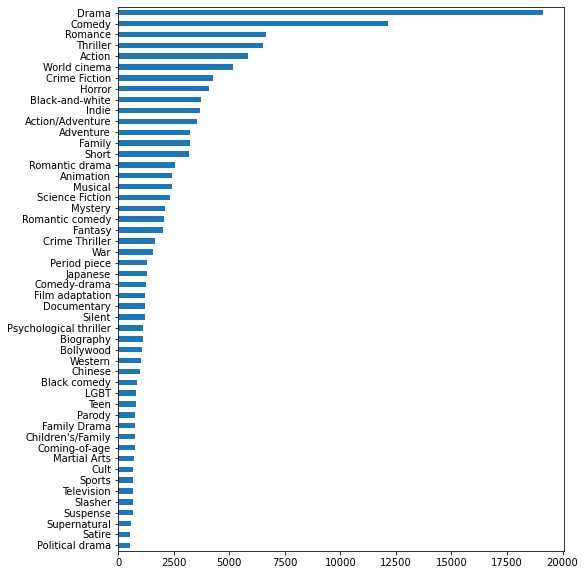

In [5]:
#distribution of top 50 common genres
dist = genres.explode().value_counts(ascending = True)
dist[-50:].plot(kind = 'barh',figsize = (8,10))

In [6]:
df = df.dropna(subset = ['genres'])

### Baseline model

In [11]:
def summary_preprocessing(plot):
    
    #remove punctuation
    tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
    no_punct = plot.apply(lambda x: tokenizer.tokenize(x))
    
    #remove stopwords
    nltk.download('stopwords')
    stop_words = set(nltk.corpus.stopwords.words('english'))
    no_stopwords = no_punct.apply(lambda x: ' '.join([w for w in x if w not in stop_words]))
    
    return no_stopwords

In [12]:
def model(summary,genres):
    #tf-idf vectorizer
    multilabel_binarizer = sklearn.preprocessing.MultiLabelBinarizer()
    multilabel_binarizer.fit(genres)
    label = multilabel_binarizer.transform(genres)
    xtrain, xval, ytrain, yval = train_test_split(summary, label, test_size=0.2, random_state=9)
    tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=10000)
    xtrain_tfidf = tfidf_vectorizer.fit_transform(xtrain)
    xval_tfidf = tfidf_vectorizer.transform(xval)
    
    #OneVsRest classifier
    lr = sklearn.linear_model.LogisticRegression()
    clf = OneVsRestClassifier(lr,n_jobs = 8)
#     scores = cross_validate(clf, xtrain_tfidf, ytrain, scoring=scoring)
    clf.fit(xtrain_tfidf,ytrain)
    y_pred = clf.predict(xval_tfidf)
    
    
    #evaluation
    f1 = sklearn.metrics.f1_score(yval, y_pred, average="micro")
    return f1, multilabel_binarizer.inverse_transform(yval), multilabel_binarizer.inverse_transform(y_pred)

In [13]:
df['processed_summary'] = summary_preprocessing(df['summary'])
f1_summary, genre_summary, predict_genre_summary = model(df['processed_summary'],df['genres'])

[nltk_data] Downloading package stopwords to /home/humiao/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [16]:
phrases_joined = df['phrases'].apply(lambda x: ' '.join(x))
f1_phrase,genre_phrase, predict_genre_phrase = model(phrases_joined,df['genres'])

In [15]:
#f1_score_summary,f1_score_phrase
f1_summary

0.32884236708467196

In [17]:
predict_genre_summary

[('Comedy', 'Drama'),
 (),
 (),
 ('Horror',),
 (),
 ('Horror', 'Slasher'),
 ('Comedy',),
 ('Comedy',),
 ('Comedy',),
 ('Horror',),
 ('Drama', 'Romance'),
 ('Drama',),
 ('Comedy',),
 ('Action', 'Horror'),
 ('Drama', 'Romance'),
 ('Comedy',),
 (),
 ('Comedy', 'Drama', 'Romance'),
 ('Action', 'Adventure'),
 (),
 (),
 ('Drama',),
 ('Mystery', 'Thriller'),
 ('Black-and-white', 'Comedy', 'Romance'),
 (),
 ('Comedy',),
 ('Drama',),
 ('Drama', 'Romance'),
 ('Drama',),
 (),
 (),
 ('Action', 'Crime Fiction', 'Crime Thriller', 'Drama', 'Mystery', 'Thriller'),
 (),
 (),
 ('Drama',),
 ('Drama',),
 ('Drama',),
 (),
 ('Drama',),
 ('Horror',),
 ('Drama',),
 ('Action/Adventure',),
 ('Documentary',),
 (),
 ('Thriller',),
 ('Action', 'Action/Adventure', 'Western'),
 ('Adventure', 'Thriller'),
 (),
 ('Comedy',),
 ('Drama', 'Romance'),
 (),
 ('Comedy',),
 ('Drama',),
 (),
 (),
 (),
 ('Drama',),
 ('Drama',),
 ('Horror', 'Thriller'),
 ('Drama', 'Japanese', 'World cinema'),
 (),
 (),
 (),
 ('Comedy',),
 ('Dra

In [18]:
predict_genre_phrase

[('Drama',),
 (),
 (),
 (),
 ('Adventure', 'Fantasy'),
 ('Comedy',),
 ('Comedy',),
 (),
 (),
 ('Horror',),
 ('Drama',),
 ('Drama',),
 ('Comedy',),
 (),
 ('Drama',),
 (),
 ('Animation', 'Short'),
 ('Comedy', 'Drama', 'Romance'),
 ('Action', 'Action/Adventure'),
 (),
 (),
 ('Drama',),
 (),
 ('Romance',),
 (),
 (),
 (),
 ('Drama',),
 ('Drama',),
 (),
 ('Action', 'Science Fiction', 'Thriller'),
 ('Action', 'Crime Fiction', 'Crime Thriller', 'Drama', 'Thriller'),
 (),
 (),
 ('Drama',),
 ('Drama',),
 ('Drama',),
 (),
 (),
 ('Horror',),
 (),
 ('Action/Adventure',),
 ('Documentary',),
 (),
 ('Crime Fiction', 'Drama', 'Thriller'),
 ('Action', 'Action/Adventure', 'Western'),
 (),
 ('Drama',),
 ('Comedy',),
 ('Drama',),
 ('Drama',),
 ('Comedy',),
 ('Drama',),
 ('Adventure',),
 ('Adventure', 'Comedy'),
 ('Comedy', 'Romance'),
 ('Drama',),
 ('Drama',),
 ('Horror', 'Thriller'),
 ('Drama', 'World cinema'),
 ('Comedy',),
 (),
 ('Drama',),
 ('Comedy', 'Drama'),
 (),
 (),
 ('Drama',),
 (),
 ('Action', '

### Evaluation metrics

#### percentage of labels that were predicted correctly

In [19]:
total_label = sum(genres.apply(len))
total_label

149300

In [20]:
print(np.sum([len(set(a).intersection(b)) for a, b in zip(pd.Series(predict_genre_phrase), pd.Series(genre_phrase))]))
print(np.sum([len(set(a).intersection(b)) for a, b in zip(pd.Series(predict_genre_summary), pd.Series(genre_summary))]))
print(np.sum([len(set(a).intersection(b))>0 for a, b in zip(pd.Series(predict_genre_phrase), pd.Series(genre_phrase))]))
print(np.sum([len(set(a).intersection(b))>0 for a, b in zip(pd.Series(predict_genre_summary), pd.Series(genre_summary))]))

5938
6346
4511
4822


In [21]:
np.sum([len(set(a).intersection(b)) for a, b in zip(pd.Series(predict_genre_summary), pd.Series(genre_summary))])

6346

In [22]:
np.sum([len(set(a).intersection(b))>0 for a, b in zip(pd.Series(predict_genre_phrase), pd.Series(genre_phrase))])

4511

In [23]:
np.sum([len(set(a).intersection(b))>0 for a, b in zip(pd.Series(predict_genre_summary), pd.Series(genre_summary))])

4822

In [24]:
summary_left_out = pd.Series(list(set(b).intersection(a)) for a, b in zip(pd.Series(predict_genre_summary), \
                                                                pd.Series(genre_summary))).explode().value_counts()
phrase_left_out = pd.Series(list(set(b).intersection(a)) for a, b in zip(pd.Series(predict_genre_phrase), \
                                                                pd.Series(genre_phrase))).explode().value_counts()

dstr = pd.Series(genre_summary).explode().value_counts()

In [25]:
left_out_pctg = (summary_left_out/dstr)
left_out_pctg_phrase = (phrase_left_out/dstr)
left_out_pctg.loc[~left_out_pctg.isnull()].rename('summary_pctg').to_frame().merge(left_out_pctg_phrase.rename('phrase_pctg'),how = 'left',left_index = True, right_index = True)\
.merge(dstr.rename('dstr'),how = 'left',left_index = True,right_index = True).sort_values(ascending = False,by = 'summary_pctg')

,summary_pctg,phrase_pctg,dstr
Drama,0.655065,0.640000,3850
Comedy,0.418807,0.334300,2414
Horror,0.412736,0.380896,848
Short,0.347896,0.330097,618
War,0.330097,0.297735,309
Animation,0.301031,0.276289,485
Science Fiction,0.276498,0.269585,434
Thriller,0.272209,0.246944,1227
Action,0.270175,0.250877,1140
Documentary,0.251938,0.135659,258


### Subset of genres

In [26]:
genre_subset = ['Drama','Comedy','Romance','Thriller','Action','Horror']
df['subset_genres'] = df['genres'].apply(lambda x: [i for i in x if i in genre_subset])
df['subset_genres'] = df['subset_genres'].apply(lambda x: np.nan if len(x)==0 else x)
subset_df = df.dropna(subset = ['subset_genres'])

In [29]:
subset_df['processed_summary'] = summary_preprocessing(subset_df['summary'])
# subset_labels = genre_to_label(subset_df['subset_genres'])
f1_summary_, genre_summary, predict_genre_summary = model(subset_df['processed_summary'],subset_df['subset_genres'])

[nltk_data] Downloading package stopwords to /home/humiao/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [30]:
subset_phrases_joined = subset_df['phrases'].apply(lambda x: ' '.join(x))
f1_phrase_, genre_phrase, predict_genre_phrase = model(subset_phrases_joined,subset_df['subset_genres'])

In [31]:
print(np.sum([len(set(a).intersection(b)) for a, b in zip(pd.Series(predict_genre_phrase), pd.Series(genre_phrase))]))
print(np.sum([len(set(a).intersection(b)) for a, b in zip(pd.Series(predict_genre_summary), pd.Series(genre_summary))]))
print(np.sum([len(set(a).intersection(b))>0 for a, b in zip(pd.Series(predict_genre_phrase), pd.Series(genre_phrase))]))
print(np.sum([len(set(a).intersection(b))>0 for a, b in zip(pd.Series(predict_genre_summary), pd.Series(genre_summary))]))

5573
5932
4930
5220


### parameter tuning

In [32]:
def model_gs(summary,genres):
    #tf-idf vectorizer
    multilabel_binarizer = sklearn.preprocessing.MultiLabelBinarizer()
    multilabel_binarizer.fit(genres)
    label = multilabel_binarizer.transform(genres)
    xtrain, xval, ytrain, yval = train_test_split(summary, label, test_size=0.2, random_state=9)
    tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=10000)
    xtrain_tfidf = tfidf_vectorizer.fit_transform(xtrain)
    xval_tfidf = tfidf_vectorizer.transform(xval)
    
    #OneVsRest classifier
    

    parameters = {
        "estimator__penalty": ['l1'],
#         "estimator__solver":['newton-cg','lbfgs', 'liblinear', 'sag', 'saga'],
        "estimator__solver":[ 'liblinear', 'lbfgs'],
        "estimator__C":[1,3],
    }
    lr = sklearn.linear_model.LogisticRegression()
    clf = OneVsRestClassifier(lr,n_jobs = 8)
    model_tunning = GridSearchCV(clf, param_grid=parameters,cv = 3, verbose = 3, scoring = 'f1_micro',refit = True)
#     scores = cross_validate(clf, xtrain_tfidf, ytrain, scoring=scoring)
    model_tunning.fit(xtrain_tfidf,ytrain)
#     y_pred = clf.predict(xval_tfidf)
    
    
    #evaluation
#     f1 = sklearn.metrics.f1_score(yval, y_pred, average="micro")
    return model_tunning.best_score_,model_tunning.best_params_, model_tunning.best_estimator_

In [34]:
score,param,est = model_gs(df['processed_summary'],df['genres'])

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV 1/3] END estimator__C=1, estimator__penalty=l1, estimator__solver=liblinear; total time=  16.3s
[CV 2/3] END estimator__C=1, estimator__penalty=l1, estimator__solver=liblinear; total time=  16.4s
[CV 3/3] END estimator__C=1, estimator__penalty=l1, estimator__solver=liblinear; total time=  16.6s
[CV 1/3] END estimator__C=1, estimator__penalty=l1, estimator__solver=lbfgs; total time=   0.9s
[CV 2/3] END estimator__C=1, estimator__penalty=l1, estimator__solver=lbfgs; total time=   1.7s
[CV 3/3] END estimator__C=1, estimator__penalty=l1, estimator__solver=lbfgs; total time=   1.6s
[CV 1/3] END estimator__C=3, estimator__penalty=l1, estimator__solver=liblinear; total time=  25.3s
[CV 2/3] END estimator__C=3, estimator__penalty=l1, estimator__solver=liblinear; total time=  23.2s
[CV 3/3] END estimator__C=3, estimator__penalty=l1, estimator__solver=liblinear; total time=  22.5s
[CV 1/3] END estimator__C=3, estimator__penalty=l1, 

In [35]:
score

0.37836532400369743

In [36]:
param

{'estimator__C': 3,
 'estimator__penalty': 'l1',
 'estimator__solver': 'liblinear'}

In [39]:
est.predict(xval_tfidf)
f1 = sklearn.metrics.f1_score(yval, y_pred, average="micro")

NameError: name 'xval_tfidf' is not defined

In [34]:
score,param = model_gs(df['phrases'].apply(lambda x: ' '.join(x)),labels,df['genres'])

Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV] estimator__C=1, estimator__penalty=l1, estimator__solver=liblinear 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  estimator__C=1, estimator__penalty=l1, estimator__solver=liblinear, score=0.304, total=   5.4s
[CV] estimator__C=1, estimator__penalty=l1, estimator__solver=liblinear 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.4s remaining:    0.0s


[CV]  estimator__C=1, estimator__penalty=l1, estimator__solver=liblinear, score=0.303, total=   5.6s
[CV] estimator__C=1, estimator__penalty=l1, estimator__solver=liblinear 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   11.1s remaining:    0.0s


[CV]  estimator__C=1, estimator__penalty=l1, estimator__solver=liblinear, score=0.300, total=   5.7s
[CV] estimator__C=1, estimator__penalty=l1, estimator__solver=lbfgs ..
[CV]  estimator__C=1, estimator__penalty=l1, estimator__solver=lbfgs, score=nan, total=   0.7s
[CV] estimator__C=1, estimator__penalty=l1, estimator__solver=lbfgs ..
[CV]  estimator__C=1, estimator__penalty=l1, estimator__solver=lbfgs, score=nan, total=   1.4s
[CV] estimator__C=1, estimator__penalty=l1, estimator__solver=lbfgs ..
[CV]  estimator__C=1, estimator__penalty=l1, estimator__solver=lbfgs, score=nan, total=   1.5s
[CV] estimator__C=1, estimator__penalty=l2, estimator__solver=liblinear 
[CV]  estimator__C=1, estimator__penalty=l2, estimator__solver=liblinear, score=0.278, total=   7.4s
[CV] estimator__C=1, estimator__penalty=l2, estimator__solver=liblinear 
[CV]  estimator__C=1, estimator__penalty=l2, estimator__solver=liblinear, score=0.278, total=   5.9s
[CV] estimator__C=1, estimator__penalty=l2, estimator

[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:  2.3min finished


In [35]:
score

0.34914278908655466

In [37]:
param

{'estimator__C': 3,
 'estimator__penalty': 'l1',
 'estimator__solver': 'liblinear'}

### pick sentence

In [47]:
import spacy
import numpy as np
import pandas as pd
from tqdm import tqdm
# from pandarallel import pandarallel
from sentence_transformers import SentenceTransformer
from sklearn.preprocessing import normalize
from sklearn.neighbors import NearestNeighbors
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer


spacy_en = spacy.load("en_core_web_sm")


def pick_rep_sentences(row, n=5):
    """
    Pick sentences with highest average sublinear word tf-idfs
    as the representatives of the full text.
    """
    summary, phrases = row.summary, row.phrases

    spacy_doc = spacy_en(summary)
    sents = np.array([s.text for s in spacy_doc.sents])
    if len(sents) <= n:
        return sents
    if not phrases:
        return np.random.choice(sents, n, replace=False)

    cntv = CountVectorizer(vocabulary=phrases)
    tfidf = TfidfTransformer(sublinear_tf=True)
    ranks = (
        tfidf.fit_transform(cntv.fit_transform(sents)).toarray().sum(axis=1)
    )
    ranks /= np.array([len(s) for s in spacy_doc.sents])
    return sents[np.argpartition(-ranks, n)[:n]]


In [49]:
sents = df.apply(pick_rep_sentences, axis = 1)

KeyboardInterrupt: 

In [ ]:
score,param,est = model_gs(sents.apply(lambda x: ' '.join(x)),df['genres'])